In [1]:
import matplotlib.pyplot as plt
from mpi4py import MPI
from eigentools import Eigenproblem, CriticalFinder
import time
import dedalus.public as de
import numpy as np

import scipy.linalg
import scipy.sparse.linalg

In [2]:
z = de.Chebyshev('z',96)
d = de.Domain([z],comm=MPI.COMM_SELF)

orr_somerfeld = de.EVP(d,['w','wz','wzz','wzzz'],'c')
orr_somerfeld.parameters['alpha'] = 1.
orr_somerfeld.parameters['Re'] = 10000.
#orr_somerfeld.substitutions['sigma'] = '-1j*alpha*Re*c'
orr_somerfeld.substitutions['umean']= '1 - z**2'
orr_somerfeld.substitutions['umeanzz']= '-2'

#orr_somerfeld.add_equation('dz(wzzz) - 2*alpha**2*wzz + alpha**4*w - sigma*(wzz-alpha**2*w)-1j*alpha*(Re*(1-z**2)*(wzz-alpha**2*w) + 2*Re*w) = 0 ')
orr_somerfeld.add_equation('dz(wzzz) - 2*alpha**2*wzz + alpha**4*w -1j*alpha*Re*((umean-c)*(wzz - alpha**2*w) - umeanzz*w) = 0')
orr_somerfeld.add_equation('dz(w)-wz = 0')
orr_somerfeld.add_equation('dz(wz)-wzz = 0')
orr_somerfeld.add_equation('dz(wzz)-wzzz = 0')

orr_somerfeld.add_bc('left(w) = 0')
orr_somerfeld.add_bc('right(w) = 0')
orr_somerfeld.add_bc('left(wz) = 0')
orr_somerfeld.add_bc('right(wz) = 0')

# create an Eigenproblem object
EP = Eigenproblem(orr_somerfeld)

2020-12-09 17:26:59,444 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2020-12-09 17:26:59,517 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


In [3]:
EPs = Eigenproblem(orr_somerfeld)

2020-12-09 17:26:59,579 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


In [4]:
EP.solve(sparse=False)

In [5]:
EPs.solve(sparse=True, N=50)

In [6]:
ev_SH = EP.evalues_good.copy()

In [7]:
def pseudo(L,xlim,ylim, size):
    xrange = np.linspace(xlim[0],xlim[1], size)
    yrange = np.linspace(ylim[0],ylim[1], size)
    R = np.zeros((size,size))
    matsize = L.shape[0]
    for j, y in enumerate(yrange):
        for i,x in enumerate(xrange):
            z = x + 1j*y
            R[j,i] = np.linalg.norm((z*np.eye(matsize) - L),ord=-2)
    return R,xrange,yrange

In [8]:
E = (EP.solver.pencils[0].M_exp).toarray()
A = (EP.solver.pencils[0].L_exp).toarray()

In [9]:
mu=0.25
pr = EP.solver.pencils[0].pre_right
V = np.linalg.inv(pr.toarray())@EPs.solver.eigenvectors

#V= EPs.solver.eigenvectors
Q,R = np.linalg.qr(V)

Ghat = Q.conj().T@(np.linalg.inv(A-mu*E)@E)@Q
I = np.eye(Ghat.shape[0])

Gmu = np.linalg.inv(Ghat)+mu*I

In [10]:
OS_pseudo, OS_x, OS_y = pseudo(Gmu,[-1,0],[-1,1],100)

(-1.0, 0.1)

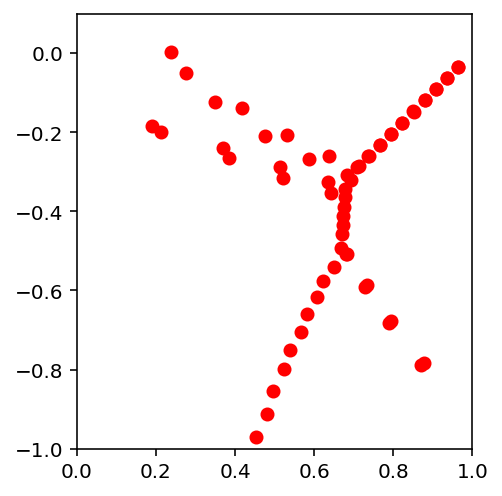

In [15]:
plt.scatter(EP.evalues_low.real, EP.evalues_low.imag,color='red')
#plt.contour(-OS_x, -OS_y, np.log10(OS_pseudo),levels=[-8,-7,-6,-5,-4,-3,-2,-1],colors='k')
plt.axis('square')
#plt.colorbar()
plt.xlim(0,1)
plt.ylim(-1,0.1)

In [16]:
96/48

2.0